# Assignment 1 Shipment Delay Prediction

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import joblib
from flask import Flask, request, jsonify

In [5]:
# Step 1: Load the Dataset
data_path = "AI_ML_Internship_Problems.csv" 
data = pd.read_csv(data_path)

In [6]:
# Step 2: Data Cleaning
# Check for missing values
print("Missing Values:")
print(data.isnull().sum())

Missing Values:
Shipment ID                0
Origin                     0
Destination                0
Shipment Date              0
Planned Delivery Date      0
Actual Delivery Date       0
Vehicle Type             597
Distance (km)              0
Weather Conditions         0
Traffic Conditions         0
Delayed                    0
dtype: int64


In [7]:
# Handle missing values (example: drop rows with missing values)
data_cleaned = data.dropna().copy()  # Add .copy() to ensure it's a separate object
# Verify if null values are dropped
print("Null values after cleaning:")
print(data_cleaned.isnull().sum())

Null values after cleaning:
Shipment ID              0
Origin                   0
Destination              0
Shipment Date            0
Planned Delivery Date    0
Actual Delivery Date     0
Vehicle Type             0
Distance (km)            0
Weather Conditions       0
Traffic Conditions       0
Delayed                  0
dtype: int64


In [8]:
# Drop the unwanted columns
data_cleaned = data_cleaned.drop(columns=['Shipment ID', 'Origin', 'Destination', 'Shipment Date', 'Planned Delivery Date', 'Actual Delivery Date'])
print(data_cleaned.head())

  Vehicle Type  Distance (km) Weather Conditions Traffic Conditions Delayed
0      Trailer           1603               Rain              Light     Yes
1      Trailer           1237              Storm           Moderate     Yes
2        Truck           1863              Clear              Light      No
3    Container           1374              Clear              Light      No
4    Container            676              Clear              Heavy     Yes


In [9]:
# Remove duplicates
data_cleaned = data_cleaned.drop_duplicates()
# Verify the cleaned data
print(data_cleaned.head())

  Vehicle Type  Distance (km) Weather Conditions Traffic Conditions Delayed
0      Trailer           1603               Rain              Light     Yes
1      Trailer           1237              Storm           Moderate     Yes
2        Truck           1863              Clear              Light      No
3    Container           1374              Clear              Light      No
4    Container            676              Clear              Heavy     Yes


In [10]:
# Check for duplicate rows
duplicates = data_cleaned.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
data_cleaned = data_cleaned.drop_duplicates()

Number of duplicate rows: 0


In [11]:
# Step 3: Exploratory Data Analysis (EDA)
# Summary statistics
print("\nSummary Statistics:")
print(data_cleaned.describe())


Summary Statistics:
       Distance (km)
count   15909.000000
mean     1099.611226
std       521.498972
min       200.000000
25%       646.000000
50%      1097.000000
75%      1551.000000
max      2000.000000


In [12]:
# Define the bins for the distance ranges
bins = [0, 500, 1000, 1500, 2000]
# Define the labels for each bin
labels = [0, 1, 2, 3]
# Apply encoding using pd.cut()
data_cleaned['Distance (km)'] = pd.cut(data_cleaned['Distance (km)'], bins=bins, labels=labels, right=True)
print(data_cleaned.head())

  Vehicle Type Distance (km) Weather Conditions Traffic Conditions Delayed
0      Trailer             3               Rain              Light     Yes
1      Trailer             2              Storm           Moderate     Yes
2        Truck             3              Clear              Light      No
3    Container             2              Clear              Light      No
4    Container             1              Clear              Heavy     Yes


In [13]:
# Define mappings for encoding
vehicle_mapping = {'Lorry': 0, 'Truck': 1, 'Trailer': 2, 'Container': 3}
weather_mapping = {'Clear': 0, 'Rain': 1, 'Fog': 2, 'Storm': 3}
traffic_mapping = {'Light': 0, 'Moderate': 1, 'Heavy': 2}
delayed_mapping = {'Yes': 0, 'No': 1}

# print(data_cleaned['Vehicle Type'].unique())
# print(data_cleaned['Weather Conditions'].unique())
# print(data_cleaned['Traffic Conditions'].unique())
# print(data_cleaned['Delayed'].unique())



data_cleaned['Vehicle Type'] = data_cleaned['Vehicle Type'].map(vehicle_mapping)
data_cleaned['Weather Conditions'] = data_cleaned['Weather Conditions'].map(weather_mapping)
data_cleaned['Traffic Conditions'] = data_cleaned['Traffic Conditions'].map(traffic_mapping)
data_cleaned['Delayed'] = data_cleaned['Delayed'].map(delayed_mapping)

print(data_cleaned.head())

   Vehicle Type Distance (km)  Weather Conditions  Traffic Conditions  Delayed
0             2             3                   1                   0        0
1             2             2                   3                   1        0
2             1             3                   0                   0        1
3             3             2                   0                   0        1
4             3             1                   0                   2        0


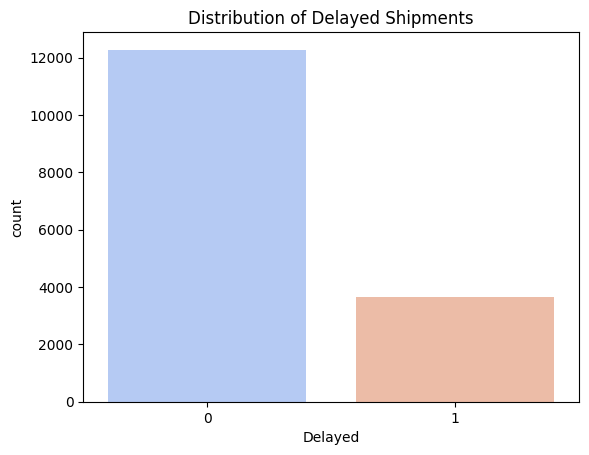

In [14]:
# Distribution of the target variable
sns.countplot(data=data_cleaned, x='Delayed', hue='Delayed', palette='coolwarm', legend=False)
plt.title('Distribution of Delayed Shipments')
plt.show()

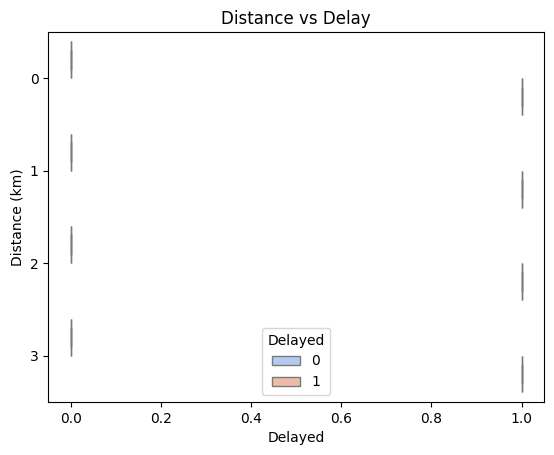

In [15]:
# Relationship between Distance and Delay
sns.boxplot(x='Delayed', y='Distance (km)', data=data_cleaned, palette='coolwarm', hue='Delayed', legend=True)
plt.title('Distance vs Delay')
plt.show()

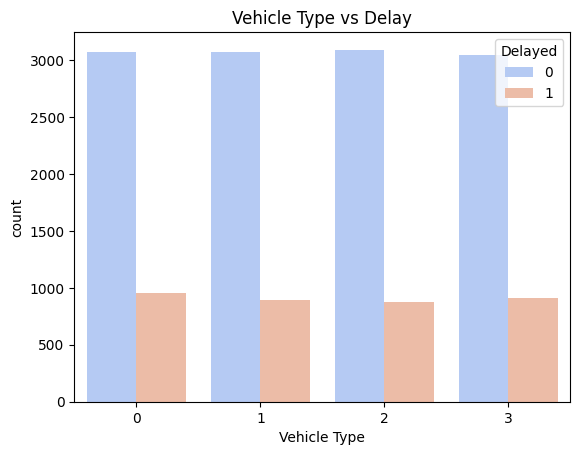

In [16]:
# Analyze Vehicle Type vs Delay
sns.countplot(data=data_cleaned, x='Vehicle Type', hue='Delayed', palette='coolwarm')
plt.title('Vehicle Type vs Delay')
plt.show()

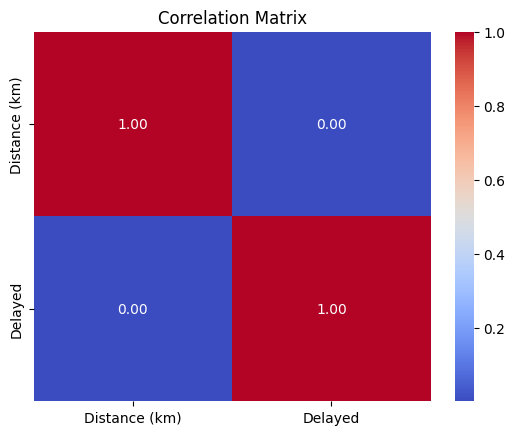

In [17]:
# Correlation Matrix (for numerical features)
numerical_features = ['Distance (km)']
correlation_matrix = data_cleaned[numerical_features + ['Delayed']].apply(lambda x: pd.factorize(x)[0]).corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [18]:
# Save cleaned data for model development
data_cleaned.to_csv("cleaned_data.csv", index=False)
print("Cleaned data saved to 'cleaned_data.csv'.")
print(data_cleaned.head())



Cleaned data saved to 'cleaned_data.csv'.
   Vehicle Type Distance (km)  Weather Conditions  Traffic Conditions  Delayed
0             2             3                   1                   0        0
1             2             2                   3                   1        0
2             1             3                   0                   0        1
3             3             2                   0                   0        1
4             3             1                   0                   2        0


In [19]:
# Split the dataset
X = data_cleaned.drop(['Delayed'], axis=1)
y = data_cleaned['Delayed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
# Experiment with Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)

In [21]:
# Experiment with Decision Tree
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)
y_pred_tree = decision_tree_model.predict(X_test)

In [22]:
# Experiment with Random Forest
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)
y_pred_forest = random_forest_model.predict(X_test)
print(data_cleaned.head())


   Vehicle Type Distance (km)  Weather Conditions  Traffic Conditions  Delayed
0             2             3                   1                   0        0
1             2             2                   3                   1        0
2             1             3                   0                   0        1
3             3             2                   0                   0        1
4             3             1                   0                   2        0


In [24]:
# Evaluate Models
def evaluate_model(y_test, y_pred, model_name):
    print(f"Evaluation for {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("\n")

if 'y_pred_logistic' in locals():
    evaluate_model(y_test, y_pred_logistic, "Logistic Regression")
    evaluate_model(y_test, y_pred_tree, "Decision Tree")
    evaluate_model(y_test, y_pred_forest, "Random Forest")

Evaluation for Logistic Regression
Accuracy: 0.9063482086737901
Precision: 0.7142857142857143
Recall: 1.0
F1 Score: 0.8333333333333333


Evaluation for Decision Tree
Accuracy: 0.9063482086737901
Precision: 0.7142857142857143
Recall: 1.0
F1 Score: 0.8333333333333333


Evaluation for Random Forest
Accuracy: 0.9063482086737901
Precision: 0.7142857142857143
Recall: 1.0
F1 Score: 0.8333333333333333




In [25]:
# Save the best model
best_model = random_forest_model  # Assuming Random Forest performed best
joblib.dump(best_model, 'shipment_delay_model.pkl')

['shipment_delay_model.pkl']

In [26]:
def predict():
    data = {
    "Vehicle Type": 1,
    "Distance (km)": 2,
    "Weather Conditions": 3,
    "Traffic Conditions": 2
    }
    input_data = pd.DataFrame([data])
    for col in ['Vehicle Type', 'Distance (km)', 'Weather Conditions', 'Traffic Conditions']:
        if col in input_data:
            input_data[col] = pd.factorize(data_cleaned[col])[0][input_data[col]]
    prediction = best_model.predict(input_data)[0]
    if prediction == 1: print('Yes')
    else: print('No')
predict()

No
